---

# InClass Kaggle Competition - Example - Python - v5.3

This notebook gives an example on the implementation of machine learning pipeline for the InClass Kaggle Competition.

Last update on: 22/03/2022

---

The machine learning pipeline includes:

1. Data processing (Part 2)
- [x] Error correction
- [x] Feature engineering
- [x] Value transformation
- [x] Value representation
- [x] Variable selection

2. Modeling (Part 3)
- [x] Logistic Regression, Random Forest, XGBoost
- [x] Hyper parameter tuning

3. Experimental setup (Part 3)
- [x] k-fold CV
- [x] Oversampling [DROPPED]

4. Debuging (Part 3)
- [x] Analyzing k-fold CV
- [x] Learning curve

In [1]:
%%time
# Version
exp_version = 'v5.3'  # Experiment version
data_prep = 'full'  # full = data transformation, representation, std = standard, only dummy encode
var_set = 'all'  # all = all vars, fs = top fisher score, pca = first PCs
fname = '_' + data_prep + '_' + var_set + '_' + exp_version  # Name of output file
print(fname)

_full_all_v5.3
Wall time: 997 µs


In [2]:
%%time
###################################################################
# MODIFY THESE FLAGS TO TURN ON/OFF THE DATA PROCESSING FUNCTIONS #
###################################################################

# Flag variables to run the data processing steps
# Feature engineering step
enable_num_poly = True  # Add polynomial terms
# Value transformation step
enable_trans_cat_dt = True  # Remapping cat variables - Decision tree–based remapping
enable_trans_num_dt = True  # Discretizing num variables - Decision tree–based discretization
enable_trans_num_ef = True  # Discretizing num variables - Equal frequency discretization
enable_trans_num_ew = True  # Discretizing num variables - Equal width discretization
# Value representation step
enable_repr_dummy = True  # Represent cat variables - Dummy coding
enable_repr_icd = True  # Represent cat variables - Incidence (of target variable) replacement
enable_repr_woe = True  # Represent cat variables - Weight-of-Evidence (WoE) conversion
drop_cat_vars = True  # Drop cat variables after value representation step
# Other data processing
enable_normalize = True  # Normalize the data to the same range [0, 1]

Wall time: 996 µs


## Initiation

In [3]:
%%time
# Data exploration
import matplotlib.pyplot as plt

# Data processing
import pickle
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

# Experimental setup
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, GridSearchCV
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve

Wall time: 2.62 s


## 1. Data summary

#### (a) Read and print out some data

In [4]:
%%time
# Read train, test
train = pd.read_csv('./data/processed/g1/bank_mkt_train.csv', low_memory=False)
test = pd.read_csv('./data/processed/g1/bank_mkt_test.csv', low_memory=False)

Wall time: 87.8 ms


In [5]:
%%time
# Print out to check the data
print(train.dtypes.value_counts())
train.head()

object     10
float64     9
int64       2
dtype: int64
Wall time: 2 ms


,client_id,age,job,marital,education,default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribe
0,29925,42.0,management,married,basic.9y,no,no,no,cellular,jul,...,1.0,999.0,0.0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,0
1,37529,35.0,unemployed,married,university.degree,no,yes,no,telephone,jun,...,4.0,999.0,0.0,nonexistent,1.4,94.465,-41.8,4.960,5228.1,0
2,2757,44.0,technician,married,basic.9y,no,yes,yes,cellular,may,...,1.0,999.0,0.0,nonexistent,-1.8,92.893,-46.2,1.264,5099.1,0
3,9642,45.0,services,married,high.school,no,yes,no,cellular,apr,...,1.0,999.0,0.0,nonexistent,-1.8,93.075,-47.1,1.453,5099.1,0
4,14183,45.0,unknown,married,unknown,unknown,unknown,unknown,telephone,may,...,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,0


#### (b) Create a list of column names to manage variables

In [6]:
%%time
# General list of variables
id_var = ["client_id"]  # ID
target_var = ["subscribe"]  # Target get variable
predictors = [v for v in train.columns if v not in id_var + target_var]

# List of numerical and catergorical variables
num_vars = ['age', 'campaign', 'pdays', 'previous',
            'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
cat_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan',
            'contact', 'month', 'day_of_week',
            'poutcome']

# Double check the list of variables
assert(len(predictors) == len(num_vars) + len(cat_vars))

Wall time: 0 ns


#### (c) Check the target variable class distribution

In [7]:
%%time
# By number
print(train[target_var].value_counts())

# By percentage
print(train[target_var].value_counts(normalize=True))

subscribe
0            17729
1             2271
dtype: int64
subscribe
0            0.88645
1            0.11355
dtype: float64
Wall time: 7.98 ms


## 2. Processing data

### 2.1. Error, data correction

#### (a) Check and correct data error - Constant variables

Constant variables on train do not contain information and may cause data processing or model training error.

In [8]:
%%time
# Count number of unique values of each variable
vars_nunique = train[num_vars + cat_vars].apply(pd.Series.nunique, dropna=False, axis=0)
cont_vars = vars_nunique.index[vars_nunique < 2].tolist()
print("Drop constant variable:", cont_vars)

# Correct variable list
num_vars = [v for v in num_vars if v not in cont_vars]
cat_vars = [v for v in cat_vars if v not in cont_vars]

# Update train, test
train = train[id_var + num_vars + cat_vars + target_var]
test = test[id_var + num_vars + cat_vars]

Drop constant variable: []
Wall time: 28.9 ms


#### (b) Check and correct data error - Missing values

<u>Note:</u>
- Always create indicators (dummy variable) to track the missing values imputation.
- Since we already filtered out the constant NA vars, the imputor will not drop any vars.

In [9]:
%%time
# Check missing value
print('Train - # NA of num vars:', train[num_vars].isna().sum().sum())
print('Train - # NA of cat vars:', train[cat_vars].isna().sum().sum())
print('Test - # NA of num vars:', test[num_vars].isna().sum().sum())
print('Test - # NA of cat vars:', test[cat_vars].isna().sum().sum())

Train - # NA of num vars: 1730
Train - # NA of cat vars: 1934
Test - # NA of num vars: 918
Test - # NA of cat vars: 1057
Wall time: 22.9 ms


In [10]:
%%time
# Here, we test the effect of dropping variables with high missing percentage (>30%)
na_threshold = 0.3

# Drop num variables with more than 30% missing values
num_na_pct = train[num_vars].isnull().mean()
num_vars = num_na_pct[num_na_pct <= na_threshold].index.tolist()
print("Drop num variables with high missing pct:", num_na_pct[num_na_pct > na_threshold].tolist())

# Drop cat variables with more than 30% missing values
cat_na_pct = train[cat_vars].isnull().mean()
cat_vars = cat_na_pct[cat_na_pct <= 0.3].index.tolist()
print("Drop cat variables with high missing pct:", cat_na_pct[cat_na_pct > na_threshold].tolist())

# Update train, test
train = train[id_var + num_vars + cat_vars + target_var]
test = test[id_var + num_vars + cat_vars]

Drop num variables with high missing pct: []
Drop cat variables with high missing pct: []
Wall time: 20.9 ms


In [11]:
%%time
# List dummary variables to track missing values imputation
na_vars = []

Wall time: 0 ns


In [12]:
%%time
# Numerical variables
# Build the missing value imputor using the mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
imp.fit(train[num_vars])

# Reconstruct the list of vars + indicators
na_vars = na_vars + [num_vars[v] + "_na" for v in imp.indicator_.features_]
impute_vars = num_vars + na_vars

# Apply on train, test
train[impute_vars] = pd.DataFrame(imp.transform(train[num_vars]), columns=impute_vars)
test[impute_vars] = pd.DataFrame(imp.transform(test[num_vars]), columns=impute_vars)

Wall time: 27.9 ms


In [13]:
%%time
# Categorical variables
# Impute missing value using a new category "Missing"
# Note: If the categorical vars are imputed by most_frequent, the indicators should be added
train[cat_vars] = train[cat_vars].fillna('Missing')
test[cat_vars] = test[cat_vars].fillna('Missing')

Wall time: 24.9 ms


#### (c) Check and correct data error - Outliers in numerical variables

Here, we only check but not impute the outliers.

<u>Note:</u>
- Before correcting outliers, make sure to understand the nature of the error.
- Do not need to correct outliers for missing values indicators.

In [14]:
%%time
# Check the outliers on train, test
for v in num_vars:
    # Calculate the boundaries on train [mean-3*sd, mean+3*sd]
    mu = np.mean(train[v])
    sd = np.std(train[v])
    lower = mu - 3*sd
    upper = mu + 3*sd
    # Check outliers using the boundaries
    train_out = (train[v] < lower) | (train[v] > upper)
    test_out = (test[v] < lower) | (test[v] > upper)
    if np.sum(train_out) + np.sum(test_out) > 0:
        print(v, "has # outliers on train, test :",
              np.sum(train_out), "[", np.round(100*np.mean(train_out), 2), "% ]",
              np.sum(test_out), "[", np.round(100*np.mean(test_out), 2), "% ]")

age has # outliers on train, test : 181 [ 0.9 % ] 89 [ 0.89 % ]
campaign has # outliers on train, test : 423 [ 2.11 % ] 210 [ 2.1 % ]
pdays has # outliers on train, test : 750 [ 3.75 % ] 371 [ 3.71 % ]
previous has # outliers on train, test : 519 [ 2.6 % ] 269 [ 2.69 % ]
Wall time: 26.9 ms


#### (d) Encode categorical variables

In Python, most of the machine learning libraries will not handle non-numerical values of categorical varibales (e.g. RF). Therefore, we should encoded the categories using integer values.

<u>Note:</u>
- Here, the encoder is fitted on both train and test. Therefore, in a few special cases, there are unique categories that appear only on train, or test.

In [15]:
# %%time
# # Keep top 10 categories and combine minor categories into "Others"
# for v in cat_vars:
#     # Find the top 10 categories per cat variable
#     top10_cat = train[v].value_counts()[:10].index.tolist()
#     # Impute on train, test
#     train[v][-train[v].isin(top10_cat)] = 'Others'
#     test[v][-test[v].isin(top10_cat)] = 'Others'

In [16]:
%%time
# Encode categorical variables as integer values
# Categorical variables in any format will be converted to string
# Note: All the NA values were imputed previously
enc = OrdinalEncoder()
enc.fit(pd.concat([train[cat_vars].astype(str), test[cat_vars].astype(str)], axis=0))
# Apply on train, test
train[cat_vars] = enc.transform(train[cat_vars].astype(str))
test[cat_vars] = enc.transform(test[cat_vars].astype(str))

Wall time: 141 ms


#### (e) Finalize the processed data

Current lists of variables:
- id_var : customer ID
- num_vars : numerical variables
- cat_vars : categorical variables
- na_vars : indicators for tracking missing values, bool [False, True]
- target_var : target variable, churn [0, 1]

<u>Note:</u> If there are any variables exist in only train or test, drop them from all the data.

In [17]:
%%time
# Convert bool variable to int
train[na_vars] = train[na_vars].astype(np.int8)
test[na_vars] = test[na_vars].astype(np.int8)

Wall time: 33.9 ms


In [18]:
%%time
# Print out the final variables
print("# id_var [", len(id_var), "] :", id_var)
print("# num_vars [", len(num_vars), "] :", num_vars[:5], "...")
print("# cat_vars [", len(cat_vars), "] :", cat_vars[:5], "...")
print("# na_vars [", len(na_vars), "] :", na_vars[:5], "...")
print("# target_var [", len(target_var), "] :", target_var)

# id_var [ 1 ] : ['client_id']
# num_vars [ 9 ] : ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate'] ...
# cat_vars [ 10 ] : ['job', 'marital', 'education', 'default', 'housing'] ...
# na_vars [ 9 ] : ['age_na', 'campaign_na', 'pdays_na', 'previous_na', 'emp.var.rate_na'] ...
# target_var [ 1 ] : ['subscribe']
Wall time: 1.98 ms


In [19]:
%%time
# Sort the data according to the variables list
train = train[id_var + num_vars + cat_vars + na_vars + target_var]
test = test[id_var + num_vars + cat_vars + na_vars]
print(train.shape)
print(test.shape)

(20000, 30)
(10000, 29)
Wall time: 7.01 ms


### 2.2. Feature engineering

Since every variables are anonymized, we cannot create new variables based the meaning of current variables.

In other case, we can use the following hints:
- Quickly check the potentially important variables.
- Focus on the most important variables to create new variables.
- Create a cross variable framework (e.g. customer activities, date-time, events, etc.) for searching the new variables.

#### (a) Quickly detect most (potentially) important varriables - Correlation test for numerical variables

In [20]:
%%time
# Pearson's correlation for numerical variables
corr = train[num_vars + target_var].corr(method='pearson')
corr = corr[target_var[0]][:-1].dropna().sort_values(ascending=False)
print("Top 5 vars [+] correlated with target_var :"); print(corr[corr > 0][:5])
print("Top 5 vars [-] correlated with target_var :"); print(corr[corr < 0][-5:])

Top 5 vars [+] correlated with target_var :
previous         0.235584
cons.conf.idx    0.055546
age              0.034892
Name: subscribe, dtype: float64
Top 5 vars [-] correlated with target_var :
cons.price.idx   -0.137655
emp.var.rate     -0.298583
euribor3m        -0.307895
pdays            -0.332565
nr.employed      -0.354529
Name: subscribe, dtype: float64
Wall time: 18 ms


#### (b) Quickly detect most (potentially) important varriables - Mutual information

<u>Reference:</u>
- Mutual information. Link: https://en.wikipedia.org/wiki/Mutual_information
- sklearn.feature_selection.mutual_info_classif. Link: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html

In [21]:
%%time
# Check mutual information for all variables
# Note: The calculation involves a random process, therefore, the result may change if there is no
# variable with significant information.
mutual_info = mutual_info_classif(train[cat_vars], train[target_var].values.squeeze())
mutual_info = pd.Series(mutual_info, index=cat_vars)
print("Top 10 vars :"); print(mutual_info.sort_values(ascending=False)[:10])

Top 10 vars :
poutcome       0.034848
month          0.022889
job            0.011145
contact        0.010791
default        0.010349
education      0.006065
loan           0.003541
marital        0.001905
housing        0.001569
day_of_week    0.001473
dtype: float64
Wall time: 1.26 s


#### (c) Add polynomial terms for numerical variables

<u>Note:</u> We only add the polynomial terms (degree=3) for a num variable if it increases the LR model performance.

In [22]:
%%time
if enable_num_poly:
    for v in num_vars:
        # Setup the LR model
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = LogisticRegression(max_iter=200)
        parameters = {}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        
        # Fit the LR model for 1 numerical variable
        clf.fit(train[[v]], train[target_var].squeeze())
        clf_num_score = clf.best_score_
        
        # Fit the LR model for 1 numerical variable + it polynomial degree = 3
        poly = PolynomialFeatures(degree=3, include_bias=False)
        poly.fit(train[[v]])
        clf.fit(poly.transform(train[[v]]), train[target_var].squeeze())
        clf_poly_score = clf.best_score_
        
        # Add the polynomial terms to train, test
        if (clf_poly_score > 0.5) & (clf_poly_score - clf_num_score > 0.05):
            print('Variable', v, 'AUC vs. AUC poly:', clf_num_score, '-->', clf_poly_score)
            poly_vars = [v_poly.replace('x0', v) for v_poly in poly.get_feature_names()[1:]]
            num_vars = num_vars + poly_vars
            train[poly_vars] = pd.DataFrame(poly.transform(train[[v]])[:, 1:], columns=poly_vars)
            test[poly_vars] = pd.DataFrame(poly.transform(test[[v]])[:, 1:], columns=poly_vars)

Variable age AUC vs. AUC poly: 0.49299075190162284 --> 0.5908793357880742
Wall time: 6.74 s


### 2.3. Value transformation (num, cat => cat)

- Categorical variable: remapping
- Continuous variable: discretization

<u>Note:</u> Some techniques that incoporate the information from target variable may cause overfitting problem.

<u>Reference:</u>

- Coussement, K., Lessmann, S., & Verstraeten, G. (2017). A comparative analysis of data preparation algorithms for customer churn prediction: A case study in the telecommunication industry. Decision Support Systems, 95, 27-36.

In [23]:
%%time
# List of variables to track the value transformation process
trans_vars = []

Wall time: 0 ns


#### 2.3.1. Remapping categorical variables - Decision tree–based remapping

#### (a) Test the variable remmaping on a categorical variable

In [24]:
%%time
# Select a cat variable
v = "month"

# Find the best decision tree
cv = KFold(n_splits=5, random_state=1, shuffle=True)
model = DecisionTreeClassifier()
parameters = {'min_samples_leaf':(train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
clf.fit(train[[v]], train[target_var])
print("Best AUC:", clf.best_score_)
print("Best params:", clf.best_params_)
print("Number of leaves:", clf.best_estimator_.get_n_leaves())

Best AUC: 0.6389734581345676
Best params: {'min_samples_leaf': 200}
Number of leaves: 9
Wall time: 243 ms


In [25]:
%%time
# Grouping the categories into new categories (leaves) using Decision Tree
# Here, we use the decision path, the last node is the new segment of an observation
remap_v = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(train[[v]]).toarray()]

print("# original categories:", train[[v]].nunique().values[0])
print("# new remapped categories:", len(set(remap_v)), set(remap_v))

# original categories: 11
# new remapped categories: 9 {4, 6, 8, 9, 10, 12, 13, 15, 16}
Wall time: 87.8 ms


#### (b) Apply the variable remmaping for all categorical variables

<u>Note:</u> Only remap the variables if AUC > 0.5 and the number of new categories > 1.

In [26]:
%%time
if enable_trans_cat_dt:
    for v in cat_vars:
        # Find the best decision tree using CV
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = DecisionTreeClassifier()
        parameters = {'min_samples_leaf':(train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        clf.fit(train[[v]], train[target_var])
        # Remap the variable on train, test
        if (clf.best_score_ > 0.5) & (clf.best_estimator_.get_n_leaves() > 1):
            print("Remapping variable", v,
                  "from", train[[v]].nunique().values[0],
                  "to", clf.best_estimator_.get_n_leaves(), "categories")
            remap_var = v + '_remap'
            trans_vars.append(remap_var)
            train[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(train[[v]]).toarray()]
            test[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(test[[v]]).toarray()]

Remapping variable job from 13 to 11 categories
Remapping variable marital from 5 to 3 categories
Remapping variable education from 9 to 7 categories
Remapping variable default from 4 to 3 categories
Remapping variable housing from 4 to 2 categories
Remapping variable contact from 3 to 3 categories
Remapping variable month from 11 to 9 categories
Remapping variable day_of_week from 6 to 2 categories
Remapping variable poutcome from 4 to 3 categories
Wall time: 2.36 s


#### 2.3.2. Discretizing (or binning) numerical variables - Decision tree–based discretization

#### (a) Test the variable discretizing on a numerical variable

In [27]:
%%time
# Select a num variable
v = "previous"

# Find the best decision tree
cv = KFold(n_splits=5, random_state=1, shuffle=True)
model = DecisionTreeClassifier()
parameters = {'min_samples_leaf':(train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
clf.fit(train[[v]], train[target_var])
print("Best AUC:", clf.best_score_)
print("Best params:", clf.best_params_)
print("Number of leaves:", clf.best_estimator_.get_n_leaves())

Best AUC: 0.6117530671009248
Best params: {'min_samples_leaf': 200}
Number of leaves: 4
Wall time: 127 ms


In [28]:
%%time
# Grouping the categories into new categories (leaves) using Decision Tree
# Here, we use the decision path, the last node is the new segment of an observation
remap_v = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(train[[v]]).toarray()]

print("# original data range: ", [train[[v]].min().values[0], train[[v]].max().values[0]])
print("# new remapped categories:", len(set(remap_v)), set(remap_v))

# original data range:  [0.0, 6.0]
# new remapped categories: 4 {3, 4, 5, 6}
Wall time: 82.8 ms


#### (b) Apply the variable discretizing for all numerical variables

<u>Note:</u> Only bin/discretize the variables if the number of new categories > 1.

In [29]:
%%time
if enable_trans_num_dt:
    for v in num_vars:
        # Find the best decision tree using CV
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = DecisionTreeClassifier()
        parameters = {'min_samples_leaf':(train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        clf.fit(train[[v]], train[target_var])
        # Remap the variable on train, test
        if (clf.best_score_ > 0.5) & (clf.best_estimator_.get_n_leaves() > 1):
            print("Discretize variable", v,
                  "from", [train[[v]].min().values[0], train[[v]].max().values[0]],
                  "to", clf.best_estimator_.get_n_leaves(), "categories")
            remap_var = v + '_bin'
            trans_vars.append(remap_var)
            train[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(train[[v]]).toarray()]
            test[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(test[[v]]).toarray()]

Discretize variable age from [17.0, 98.0] to 25 categories
Discretize variable campaign from [1.0, 56.0] to 10 categories
Discretize variable pdays from [0.0, 999.0] to 3 categories
Discretize variable previous from [0.0, 6.0] to 4 categories
Discretize variable emp.var.rate from [-3.4, 1.4] to 8 categories
Discretize variable cons.price.idx from [92.201, 94.767] to 14 categories
Discretize variable cons.conf.idx from [-50.8, -26.9] to 15 categories
Discretize variable euribor3m from [0.634, 5.045] to 47 categories
Discretize variable nr.employed from [4963.6, 5228.1] to 9 categories
Discretize variable age^2 from [289.0, 9604.0] to 25 categories
Discretize variable age^3 from [4913.0, 941192.0] to 25 categories
Wall time: 2.87 s


#### 2.3.3. Discretizing (or binning) numerical variables - Equal frequency discretization

<u>Note:</u>  
- According to Coussement, Lessmann, & Verstraeten (2017), the number of bins at 10 is optimal. However, we can also test with different values in the range [5, 10].

#### (a) Test the variable discretizing on a numerical variable

In [30]:
%%time
# Select a num variable
v = "age"

# Binning values of a variable into new groups using equal frequency approach
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
est.fit(train[[v]])
print("Number of bins :", est.n_bins_[0])
est.bin_edges_

Number of bins : 10
Wall time: 9.97 ms


array([array([17., 28., 31., 33., 36., 38., 41., 45., 49., 55., 98.])],
      dtype=object)

In [31]:
%%time
# Apply the binning to a variable
binef_v = est.transform(train[[v]])
pd.DataFrame(binef_v).value_counts().sort_index()

Wall time: 9.02 ms


0.0    1552
1.0    1984
2.0    1784
3.0    2554
4.0    1625
5.0    2131
6.0    2151
7.0    1911
8.0    2270
9.0    2038
dtype: int64

#### (b) Apply the variable discretizing for all numerical variables

In [32]:
%%time
if enable_trans_num_ef:
    for v in num_vars:
        # Binning values of a variable
        est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
        est.fit(train[[v]])
        # Bin the variable on train, test
        if est.n_bins_[0] > 1:
            binef_var = v + '_binef'
            trans_vars.append(binef_var)
            train[binef_var] = est.transform(train[[v]])
            test[binef_var] = est.transform(test[[v]])

Wall time: 161 ms


C:\Users\phant\miniconda3\envs\py\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\phant\miniconda3\envs\py\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\phant\miniconda3\envs\py\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\phant\miniconda3\envs\py\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e.,

#### 2.3.4. Discretizing (or binning) numerical variables - Equal width discretization

#### (a) Test the variable discretizing on a numerical variable.

In [33]:
%%time
# Select a variable
v = "age"

# Binning values of a variable into new groups using equal width approach
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
est.fit(train[[v]])
print("Number of bins :", est.n_bins_[0])
est.bin_edges_

Number of bins : 10
Wall time: 5.98 ms


array([array([17. , 25.1, 33.2, 41.3, 49.4, 57.5, 65.6, 73.7, 81.8, 89.9, 98. ])],
      dtype=object)

In [34]:
%%time
# Apply the binning to a variable
binew_v = est.transform(train[[v]])
pd.DataFrame(binew_v).value_counts().sort_index()

Wall time: 5.94 ms


0.0     804
1.0    5386
2.0    6055
3.0    3858
4.0    2847
5.0     750
6.0     156
7.0      96
8.0      41
9.0       7
dtype: int64

#### (b) Apply the variable discretizing for all numerical variables

In [35]:
%%time
if enable_trans_num_ew:
    for v in num_vars:
        # Binning values of a variable
        est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
        est.fit(train[[v]])
        # Bin the variable on train, test
        if est.n_bins_[0] > 1:
            binew_var = v + '_binew'
            trans_vars.append(binew_var)
            train[binew_var] = est.transform(train[[v]])
            test[binew_var] = est.transform(test[[v]])

Wall time: 165 ms


#### 2.3.5. Finalize value transformation

- Finalize the variables list
- Arrange the data columns

<u>Note:</u> After the end of the value transformation step, we have these final lists of variables to manage:
- num_vars
- na_vars
- cat_vars = cat_vars + trans_vars

In [36]:
%%time
# Finalize the variable list
cat_vars = cat_vars + trans_vars
print("Transformed num, cat variables into # new categorical variables :", len(trans_vars))

Transformed num, cat variables into # new categorical variables : 41
Wall time: 0 ns


In [37]:
%%time
# Arrange the data columns
train = train[id_var + num_vars + cat_vars + na_vars + target_var]
test = test[id_var + num_vars + cat_vars + na_vars]
print(train.shape)
print(test.shape)

(20000, 73)
(10000, 72)
Wall time: 16 ms


### 2.4. Value representation (cat => num)

- Categorical variable: Dummy coding
- Categorical variable: Incidence replacement
- Categorical variable: Weight of Evidence (WoE) conversion

<u>Reference:</u>  

- Coussement, K., Lessmann, S., & Verstraeten, G. (2017). A comparative analysis of data preparation algorithms for customer churn prediction: A case study in the telecommunication industry. Decision Support Systems, 95, 27-36.

In [38]:
%%time
# List of variables to track the value representation process
repr_vars = []
dummy_vars = []

Wall time: 0 ns


#### 2.4.1. Dummy coding

<u>Note:</u> Here, we can fit the encoder on both train and test to make sure it captures all unique categories.

#### (a) Test the value representation on a categorical variable

In [39]:
%%time
# Select a cat variable
v = "job"

# Build the dummy encoding on [Var194]
enc = OneHotEncoder(drop="first", handle_unknown="error")
enc.fit(pd.concat([train[[v]], test[[v]]], axis=0))
enc.categories_

Wall time: 4.99 ms


[array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])]

In [40]:
%%time
# Transform a categorical variable
dummy_v = enc.transform(train[[v]])
dummy_v.toarray()

Wall time: 3.99 ms


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

#### (b) Apply the value representation for all categorical variables

In [41]:
%%time
# TODO: More efficient implementation
if enable_repr_dummy:
    # Create dummy variables, drop the first dummy column
    enc = OneHotEncoder(drop="first", handle_unknown="error")
    enc.fit(pd.concat([train[cat_vars], test[cat_vars]], axis=0))
    dummy_vars = enc.get_feature_names().tolist()
    repr_vars = repr_vars + dummy_vars
    # Transform train, test
    train_dummy = enc.transform(train[cat_vars])
    test_dummy = enc.transform(test[cat_vars])

Wall time: 218 ms


#### 2.4.2. Incidence (of target variable) replacement

#### (a) Test the value representation on a categorical variable

In [42]:
%%time
# Select a variable
v = "job"

# Find the incidence rates per category of a categorical variable
tb = pd.pivot_table(train, values=target_var, index=v, aggfunc=np.mean).reset_index()
tb.columns = [v, v + "_icd"]
tb

Wall time: 9.97 ms


,job,job_icd
0,0.0,0.093168
1,1.0,0.128818
2,2.0,0.068881
3,3.0,0.089385
4,4.0,0.106870
5,5.0,0.123944
6,6.0,0.252111
7,7.0,0.096542
8,8.0,0.081547
9,9.0,0.313776


In [43]:
%%time
# Add/join the incidence variable
pd.merge(train[[v]], tb, on=v).head()

Wall time: 11 ms


,job,job_icd
0,5.0,0.123944
1,5.0,0.123944
2,5.0,0.123944
3,5.0,0.123944
4,5.0,0.123944


#### (b) Apply the value representation for all categorical variables

In [44]:
%%time
if enable_repr_icd:
    for v in cat_vars:
        # Find the incidence rates per category of a categorical variable
        tb = pd.pivot_table(train, values=target_var, index=v, aggfunc=np.mean).reset_index()
        icd_var = v + "_icd"
        repr_vars.append(icd_var)
        tb.columns = [v, icd_var]
        # Add the incidence column to train, test
        train[icd_var] = pd.merge(train[[v]], tb, on=v)[icd_var]
        test[icd_var] = pd.merge(test[[v]], tb, on=v)[icd_var]

Wall time: 1.35 s


#### 2.4.3. Weight-of-Evidence (WoE) conversion

<u>Note:</u>
- WoE might create +/-Inf value and need to be handled before fitting machine learning model. Here, we correct problem by adding e (small value) to the the numerator and denominator of the WoE equation.

#### (a) Test the value representation on a categorical variable

In [45]:
%%time
# Select a variable
v = "job"

# Find the incidence rates per category of a categorical variable
# Add +1 before calculating the log to avoid +/-Inf
tb = train[[v] + target_var].value_counts().unstack(fill_value=0).reset_index()
e = 1e-10  # Small value
tb[v + "_woe"] = np.log((tb[1] + e) / (tb[0] + e))
tb

Wall time: 22.9 ms


subscribe,job,0,1,job_woe
0,0.0,146,15,-2.275556
1,1.0,4335,641,-1.911447
2,2.0,4177,309,-2.604007
3,3.0,652,64,-2.321161
4,4.0,468,56,-2.123117
5,5.0,1244,176,-1.955603
6,6.0,620,209,-1.087385
7,7.0,627,67,-2.236254
8,8.0,1757,156,-2.421507
9,9.0,269,123,-0.782527


In [46]:
%%time
# Add/join the WoE variable
pd.merge(train[[v]], tb[[v, v + "_woe"]], on=v).head()

Wall time: 11 ms


,job,job_woe
0,5.0,-1.955603
1,5.0,-1.955603
2,5.0,-1.955603
3,5.0,-1.955603
4,5.0,-1.955603


#### (b) Apply the value representation for all categorical variables

In [47]:
%%time
# TODO: More efficient implementation
if enable_repr_woe:
    for v in cat_vars:
        # Find the WoE per category of a categorical variable
        tb = train[[v] + target_var].value_counts().unstack(fill_value=0).reset_index()
        woe_var = v + "_woe"
        repr_vars.append(woe_var)
        e = 1e-10  # Small value
        tb[woe_var] = np.log((tb[1] + e) / (tb[0] + e))
        # Add the incidence column to train, test
        train[woe_var] = pd.merge(train[[v]], tb[[v, woe_var]], on=v)[woe_var]
        test[woe_var] = pd.merge(test[[v]], tb[[v, woe_var]], on=v)[woe_var]

Wall time: 1.99 s


#### 2.4.3. Finalize value representation 

#### (a) Drop categorical variables, add dummy variables

At the end of this step, all categorical variables were represented by dummy variables or numerical variables. Therefore, it is no need to keep categorical variables.

In [48]:
%%time
# Drop cat vars
if drop_cat_vars:
    train = train.drop(cat_vars, axis=1)
    test = test.drop(cat_vars, axis=1)
    cat_vars = []

Wall time: 33.9 ms


In [49]:
%%time
# Add dummy variables
if enable_repr_dummy:
    train = pd.concat([train, pd.DataFrame(train_dummy.toarray(), columns=dummy_vars)], axis=1)
    test = pd.concat([test, pd.DataFrame(test_dummy.toarray(), columns=dummy_vars)], axis=1)
    del train_dummy, test_dummy

Wall time: 127 ms


#### (b) Impute missing values created by value representation

During the value representation process, if the categorical variables have new categories on test, the represented values might be missing on test data. Therefore, it is necessary to correct again here.

In [50]:
%%time
# Impute new missing values on test using the mean on train
if len(repr_vars) > 0:
    imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
    imp.fit(train[repr_vars])
    test[repr_vars] = pd.DataFrame(imp.transform(test[repr_vars]), columns=repr_vars)

Wall time: 342 ms


#### (c) Finalize the variables list

<u>Note:</u> At the end of the value representation step, we have these final lists of variables to manage:
- num_vars = num_vars + repr_vars
- na_vars

In [51]:
%%time
# Combine the variable list
num_vars = num_vars + repr_vars
print("Represented cat variables with # new num variables :", len(repr_vars))

Represented cat variables with # new num variables : 505
Wall time: 999 µs


In [52]:
%%time
# Arrange the data columns
train = train[id_var + num_vars + cat_vars + na_vars + target_var]
test = test[id_var + num_vars + cat_vars + na_vars]
print(train.shape)
print(test.shape)

(20000, 527)
(10000, 526)
Wall time: 52.9 ms


### 2.5. Other data processing

#### (a) Data normalization - Numerical variables

<u>Note:</u>
- It is not necessary to normalize dummy variables since they are in [0, 1].
- With large data set, calling MinMaxScaler().fit() may cause memory issue.

In [53]:
%%time
# TODO: More efficient implementation
if enable_normalize:
    for v in num_vars:
        # Build the normalizer on train
        scaler = MinMaxScaler().fit(train[[v]])
        # Apply on train, test
        train[v] = scaler.transform(train[[v]])
        test[v] = scaler.transform(test[[v]])

Wall time: 3.36 s


####  (b) Filter out low variance variables (or constant)

During the data processing, we may accidentally create some new constant variables. Therefore, it is necessary to filter again.

In [54]:
%%time
# List of all predictors
predictors = num_vars + cat_vars + na_vars

Wall time: 0 ns


In [55]:
%%time
# Detect constant vars
sel = VarianceThreshold(0)  # Var = 0 by default
sel.fit(train[predictors])
const_vars = [predictors[i] for i in np.where(sel.variances_ == 0)[0]]
predictors = [v for v in predictors if v not in const_vars]

# Drop from train, test
print('Drop # constant vars :', len(const_vars))
train = train.drop(const_vars, axis=1)
test = test.drop(const_vars, axis=1)

Drop # constant vars : 0
Wall time: 227 ms


#### (c) Drop duplicated variables

Sometime, the data processing process can create a lot of duplicated variables. In this case, it is necessary to identify and drop them.

In [56]:
%%time
# Count the duplicated vars
dup_vars = train[predictors].T.duplicated()
print('# duplicated vars :', dup_vars.sum())

# duplicated vars : 131
Wall time: 3.95 s


In [57]:
%%time
# Drop the duplicated vars from train, test
predictors = [predictors[i] for i in range(0, len(predictors)) if not dup_vars[i]]
train = train[id_var + predictors + target_var]
test = test[id_var + predictors]

Wall time: 38.9 ms


#### (d) Export the processed data to file

In [58]:
%%time
# Print out the data to check
print(train.shape)
print(test.shape)

(20000, 396)
(10000, 395)
Wall time: 0 ns


In [59]:
%%time
# Save to pickle format
train.to_pickle("./data/processed/final/g1/train_processed" + fname + ".pkl")
test.to_pickle("./data/processed/final/g1/test_processed" + fname + ".pkl")

Wall time: 569 ms


### 2.6. Variable selection

<u>Reference:</u>  

- Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights into churn prediction in the telecommunication sector: A profit driven data mining approach. European Journal of Operational Research, 218(1), 211-229.

In [60]:
%%time
# Read back the processed data
#fname = '_std_all_v5.1'
train = pd.read_pickle("./data/processed/final/g1/train_processed" + fname + ".pkl")
test = pd.read_pickle("./data/processed/final/g1/test_processed" + fname + ".pkl")

Wall time: 40.9 ms


In [61]:
%%time
# Create several lists to handle variables
id_var = ['client_id']
target_var = ['subscribe']
predictors = [v for v in train.columns if v not in id_var + target_var]

Wall time: 0 ns


####  (a) Variable selection: Fisher Score

In [62]:
%%time
def FisherScore(bt, target_var, predictors):
    """
    This function calculate the Fisher score of a variable.

    Ref:
    ---
    Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights
    into churn prediction in the telecommunication sector: A profit driven data mining
    approach. European Journal of Operational Research, 218(1), 211-229.
    """
    
    # Get the unique values of dependent variable
    target_var_val = bt[target_var].unique()
    # Calculate FisherScore for each predictor
    predictor_FisherScore = []
    for v in predictors:
        fs = np.abs(np.mean(bt.loc[bt[target_var]==target_var_val[0], v]) - np.mean(bt.loc[bt[target_var]==target_var_val[1], v])) / \
             np.sqrt(np.var(bt.loc[bt[target_var]==target_var_val[0], v]) + np.var(bt.loc[bt[target_var]==target_var_val[1], v]))
        predictor_FisherScore.append(fs)
    return predictor_FisherScore

Wall time: 0 ns


In [63]:
%%time
# Calculate Fisher Score for all variable
fs = FisherScore(train, target_var[0], predictors)
fs_df = pd.DataFrame({"predictor":predictors, "fisherscore":fs})
fs_df = fs_df.sort_values('fisherscore', ascending=False)
fs_df.head()

Wall time: 822 ms


,predictor,fisherscore
8,nr.employed,0.738579
7,euribor3m,0.701092
4,emp.var.rate,0.669549
212,x33_4.0,0.596566
281,x47_9.0,0.580713


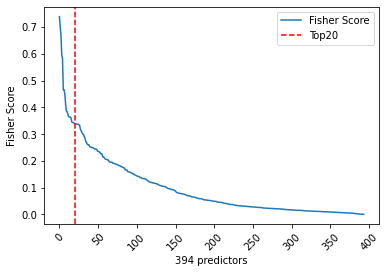

Wall time: 322 ms


In [64]:
%%time
# Visualize the Fisher Score
plt.plot(fs_df['fisherscore'].values.squeeze())
plt.axvline(x=20, linestyle='dashed', color='red')
plt.xticks(rotation=45)
plt.xlabel(str(fs_df.shape[0]) + ' predictors')
plt.ylabel('Fisher Score')
plt.legend(['Fisher Score', 'Top20'])
plt.show()

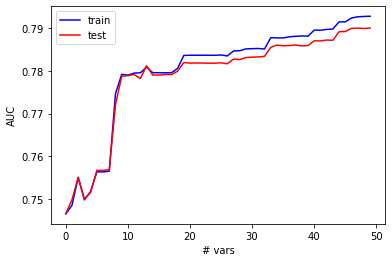

Wall time: 18.8 s


In [65]:
%%time
# Check how AUC change when add more variables: Top n vars
fs_scores = []
top_n_vars = 50
for i in range(1, top_n_vars+1):
    if i % 100 == 0: print('Added # top vars :', i)
    top_n_predictors = fs_df['predictor'][:i]
    clf = LogisticRegression()
    fs_scores.append(cross_validate(clf, train[top_n_predictors], train[target_var].values.squeeze(),
                                    scoring='roc_auc', cv=5, verbose=0, n_jobs=-1, return_train_score=True))

# How the AUC curve looks like when adding top vars
plt.plot([s['train_score'].mean() for s in fs_scores], color='blue')
plt.plot([s['test_score'].mean() for s in fs_scores], color='red')
plt.xlabel('# vars')
plt.ylabel('AUC')
plt.legend(['train', 'test'])
plt.show()

In [76]:
%%time
# Select the top variables based on Fisher Score
n_top_fs_vars = 50  # Top FS vars
top_fs_vars = fs_df['predictor'].values[:n_top_fs_vars]
print("Selected # vars :", len(top_fs_vars))
top_fs_vars

Selected # vars : 50
Wall time: 0 ns


array(['nr.employed', 'euribor3m', 'emp.var.rate', 'x33_4.0', 'x47_9.0',
       'pdays', 'x21_4', 'x9_3.0', 'x37_4.0', 'previous', 'x32_1.0',
       'x9_2.0', 'x23_14', 'x48_1.0', 'x27_16', 'x48_8.0', 'x21_3',
       'x33_2.0', 'x24_21', 'x6_2.0', 'x23_13', 'x35_5.0', 'x25_20',
       'x37_3.0', 'x27_13', 'x6_1.0', 'x46_3.0', 'x46_4.0', 'x46_6.0',
       'x45_6.0', 'x45_7.0', 'x22_6', 'x27_8', 'cons.price.idx',
       'x44_3.0', 'x46_8.0', 'x36_5.0', 'x27_9', 'x23_5', 'x23_8',
       'x13_4', 'x3_2.0', 'x27_6', 'x25_23', 'x7_7.0', 'x27_7', 'x24_5',
       'x25_17', 'x19_48', 'x43_3.0'], dtype=object)

#### (b) Dimensional Reduction: PCA

In [67]:
%%time
# Build PCA and check the explained variance
# Note: If the num vars were scaled (but the dummy were not) PVE is no longer correct
pca = PCA(n_components=len(predictors))
pca.fit(train[predictors])
print("PVE =", pca.explained_variance_ratio_.sum())
# Transform train, test
train_pca = pca.transform(train[predictors])
test_pca = pca.transform(test[predictors])

PVE = 1.0000000000000002
Wall time: 768 ms


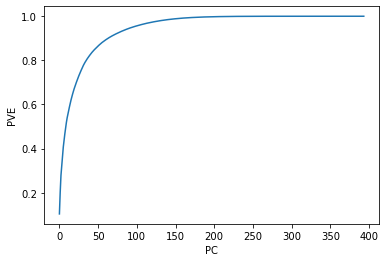

Wall time: 177 ms


In [68]:
%%time
# Visualize the PVE of PCA
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('PC')
plt.ylabel('PVE')
plt.show()

In [69]:
%%time
# Reconstruct the loading vectors
loading_vecs = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_vecs = pd.DataFrame(loading_vecs,
                            columns=['PC' + str(i) for i in list(range(1, pca.n_components_+1))],
                            index=predictors)
loading_vecs.iloc[:2, :2]

Wall time: 1.97 ms


,PC1,PC2
age,-0.010394,0.001701
campaign,-0.006541,0.000934


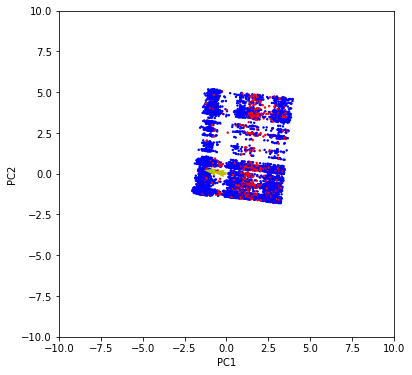

Wall time: 589 ms


In [70]:
%%time
# Visualize the group of data
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
colors = np.array(['blue'] * len(train[target_var]))
colors[train[target_var].squeeze() == 1] = 'red'
plt.scatter(x=train_pca[:, 0], y=train_pca[:, 1], color=colors, s=2)
plt.quiver([0, 0], [0, 0],
           loading_vecs.iloc[:2, :2]['PC1'].tolist(),
           loading_vecs.iloc[:2, :2]['PC2'].tolist(),
           color=['y','y'])
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## 3. Modeling

<u>Note:</u>
- Mass feature engineering may lead to overfitting. Especially with the techniques that link information from the target variable to the predictors (including Fisher Score for variable selection).
- Therefore, the k-fold cross-validation in below is convenient to use, but is not a 100% correct method to estimate the performance of the models. Train, validation and test set should be processed separately to avoid information leakage.

<u>Reference:</u>  

- Lessmann, S., Baesens, B., Seow, H. V., & Thomas, L. C. (2015). Benchmarking state-of-the-art classification algorithms for credit scoring: An update of research. European Journal of Operational Research, 247(1), 124-136.File 

In [71]:
%%time
# List of parameter tuning using cross validation for all models
model_grid = {}

Wall time: 0 ns


In [77]:
%%time
#########################################################
# MODIFY THE BELOW VALUE TO SET THE TARGET VARIABLE SET #
#########################################################
var_set = 'fs'  # all = all vars, fs = top fisher score, pca = first PCs

# Prepare the data according to the selected set of variables
if var_set == 'all':
    X = train[predictors]
    X_test = test[predictors]
    test_id = test[id_var]
elif var_set == 'fs':
    X = train[top_fs_vars]
    X_test = test[top_fs_vars]
    test_id = test[id_var]
elif var_set == 'pca':
    X = train_pca
    X_test = test_pca
    test_id = test[id_var]
y = train[target_var].values.squeeze()
print(X.shape)

# Update output file name
fname = '_' + data_prep + '_' + var_set + str(X.shape[1]) + '_' + exp_version
print(fname)

# Remove unused data
# del train, test, train_pca, test_pca

(20000, 50)
_full_fs50_v5.3
Wall time: 13 ms


### 3.1. Modeling

### 3.2. Stacking & Voting ensemble

<u>Reference:</u>
- Ensemble methods. Link: https://scikit-learn.org/stable/modules/ensemble

### 3.3. Debugging

To detect overfitting, underfitting problem, we can analyze the following analyses:
- Each fold of the k-fold CV
- Learning curve

## 4. Make prediction

Use the best model to make prediction on test set. Submit the result to Kaggle.

## 5. Other useful references

1. Dynamic Classifier Selection Ensembles in Python. Link: https://machinelearningmastery.com/dynamic-classifier-selection-in-python/
2. How to Develop a Feature Selection Subspace Ensemble in Python. Link: https://machinelearningmastery.com/feature-selection-subspace-ensemble-in-python/
3. How to Choose a Feature Selection Method For Machine Learning. Link: https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/